In [1]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
%matplotlib inline
import tensorflow as tf
from IPython.display import clear_output

In [2]:
import tensorflow as tf

# List all physical devices
physical_devices = tf.config.list_physical_devices()
print("All physical devices:", physical_devices)

# Specifically list GPU devices
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Quick test: run a simple matrix multiplication on GPU if available
if gpus:
    with tf.device('/GPU:0'):
        a = tf.random.uniform([1000, 1000])
        b = tf.random.uniform([1000, 1000])
        c = tf.matmul(a, b)
        print("Matrix multiplication result shape:", c.shape)
else:
    print("No GPU detected, running on CPU")


All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result shape: (1000, 1000)


2025-11-09 07:57:40.016409: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-09 07:57:40.016498: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-09 07:57:40.016504: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-09 07:57:40.016707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-09 07:57:40.016724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import tensorflow as tf

print("Using:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Quick GPU test
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    print(c := tf.matmul(a, b))
print("Matrix multiplication complete.")


Using: GPU
tf.Tensor(
[[-17.384455   -81.533585    19.963673   ...  -3.0636797  -43.083817
   19.611689  ]
 [  6.3267303    4.598757    24.609055   ... -21.410583     0.69634145
   -6.696166  ]
 [ 20.08228     -5.7285466  -22.836031   ... -23.755228    -1.3762189
    6.133808  ]
 ...
 [ 10.763285   -44.667713    28.880934   ...  28.697151    -0.55245775
   53.951385  ]
 [-41.637188   -13.890725   -11.239764   ...   6.2548184  -12.456603
   -3.26676   ]
 [-18.041954    12.176678   -39.088108   ...  66.28295      4.8510065
   38.306213  ]], shape=(1000, 1000), dtype=float32)
Matrix multiplication complete.


In [4]:
# Ensure the '/models' directory exists
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [6]:
import os

# Paths to your datasets
original_dataset = 'Eye Disease Image Dataset/Original Dataset'
augmented_dataset = 'Eye Disease Image Dataset/Augmented Dataset'
output_dataset = 'dataset'  # folder to save train/val/test

# Split ratios for validation and test (from original images)
val_ratio = 0.15
test_ratio = 0.20

# Get class folders, ignoring hidden/system files
class_folders = [d for d in os.listdir(original_dataset)
                 if os.path.isdir(os.path.join(original_dataset, d))]

# Initialize variables to track counts
train_counts = {}
val_counts = {}
test_counts = {}

augmented_counts = {}
remaining_original_counts = {}

# Process each class
for class_name in class_folders:
    orig_class_path = os.path.join(original_dataset, class_name)
    aug_class_path = os.path.join(augmented_dataset, class_name)
    
    # List original images, ignoring non-files
    orig_images = [f for f in os.listdir(orig_class_path)
                   if os.path.isfile(os.path.join(orig_class_path, f))]
    n_total = len(orig_images)
    
    # Calculate split sizes
    n_val = int(val_ratio * n_total)
    n_test = int(test_ratio * n_total)
    n_train = n_total - n_val - n_test
    
    # Count augmented images
    if os.path.exists(aug_class_path):
        aug_images = [f for f in os.listdir(aug_class_path)
                      if os.path.isfile(os.path.join(aug_class_path, f))]
        augmented_counts[class_name] = len(aug_images)
    else:
        augmented_counts[class_name] = 0
    
    # Count remaining original images in train/val/test
    remaining_original_counts[class_name] = {
        'train': n_train,
        'val': n_val,
        'test': n_test
    }

    # Count the images in the train, validation, and test sets
    train_counts[class_name] = len(os.listdir(os.path.join(output_dataset, 'train', class_name)))
    val_counts[class_name] = len(os.listdir(os.path.join(output_dataset, 'validation', class_name)))
    test_counts[class_name] = len(os.listdir(os.path.join(output_dataset, 'test', class_name)))




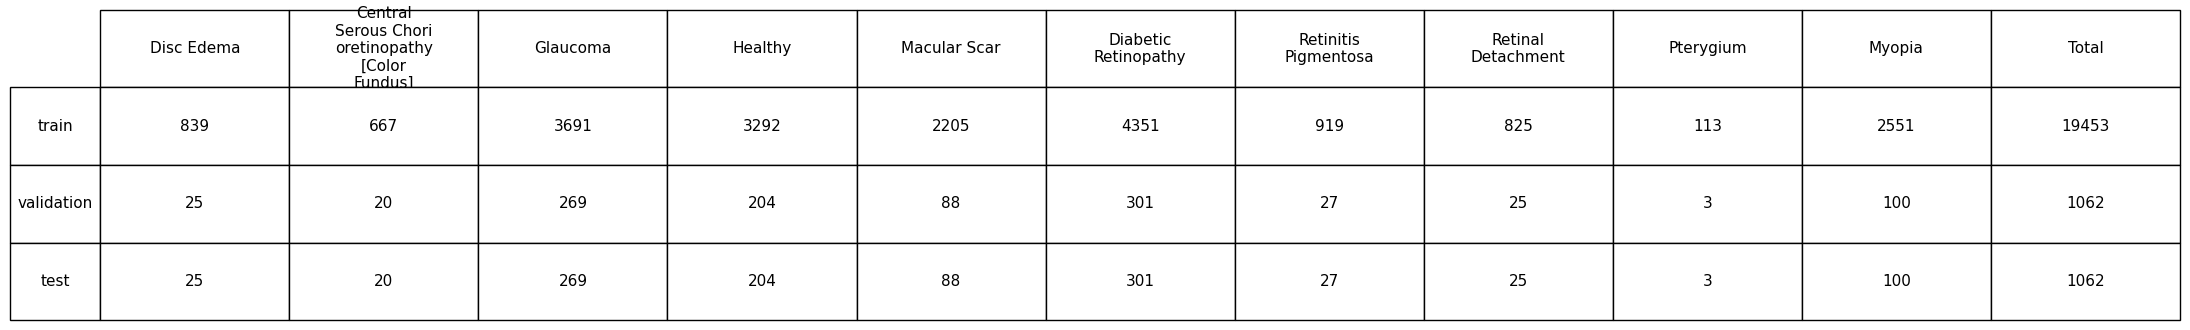

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# Prepare data
data = {}
for split in ['train', 'validation', 'test']:
    row = {}
    for class_name in class_folders:
        n = len(os.listdir(os.path.join(output_dataset, split, class_name)))
        row[class_name] = n
    data[split] = row

# Create DataFrame
df = pd.DataFrame(data).T  # splits as rows

# Add Total column (sum of all classes per split)
df['Total'] = df.sum(axis=1)

# Wrap long column headers to multiple lines for better display
def wrap_header(text, width=12):
    return "\n".join(textwrap.wrap(text, width))

wrapped_columns = [wrap_header(col) for col in df.columns]

# Plot table
fig, ax = plt.subplots(figsize=(22, len(df)*0.8 + 1))  # Slightly wider for Total column
ax.axis('off')

tbl = ax.table(cellText=df.values,
               colLabels=wrapped_columns,
               rowLabels=df.index,
               cellLoc='center',
               rowLoc='center',
               loc='center',
               colLoc='center',
               bbox=[0, 0, 1, 1])

tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1.5, 1.8)

plt.tight_layout()
plt.savefig("dataset_summary_fixed_wrapped_total.png", dpi=300)
plt.show()


In [8]:
# Define dataset paths
train_dir = "dataset/train"
val_dir = "dataset/validation"
test_dir = "dataset/test"

In [51]:
import tensorflow as tf

IMG_SIZE = (144, 144)
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123,
)

class_names = train_ds.class_names
print("Detected classes:", class_names)


Found 19453 files belonging to 10 classes.
Found 1062 files belonging to 10 classes.
Found 1062 files belonging to 10 classes.
Detected classes: ['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


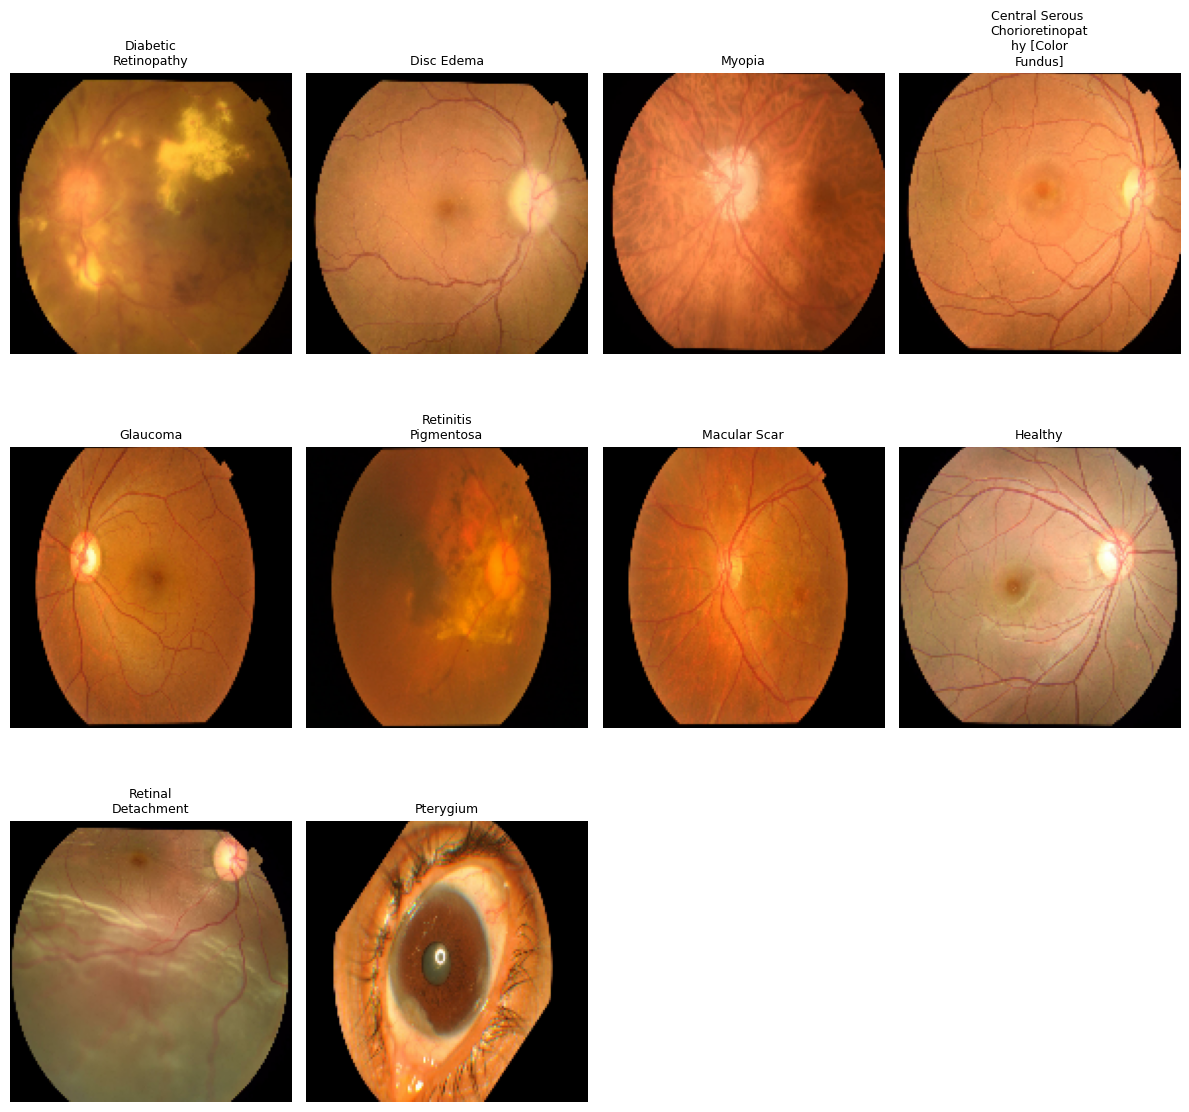

In [52]:
import matplotlib.pyplot as plt
import tensorflow as tf
import textwrap

# We'll collect one image per class
num_classes = len(class_names)
images_per_class = {}

# Iterate through dataset until we have one example for each class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        label_name = class_names[label.numpy()]
        if label_name not in images_per_class:
            images_per_class[label_name] = img.numpy().astype("uint8")
        if len(images_per_class) == num_classes:
            break
    if len(images_per_class) == num_classes:
        break

# Plot one image per class with wrapped titles and smaller font
plt.figure(figsize=(12, 12))
for i, (label_name, img) in enumerate(images_per_class.items()):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    # Wrap text at max width 15 chars
    wrapped_title = textwrap.fill(label_name, width=15)
    plt.title(wrapped_title, fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def se_block(x, ratio=4):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([x, se])

def build_se_cnn(img_size, num_classes=10, weight_decay=1e-4):
    inputs = layers.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # --- Block 1 - 
    x = layers.Conv2D(32, (3, 3), padding='same', 
                      kernel_regularizer=regularizers.l2(weight_decay),
                      kernel_initializer='he_normal')(x)  # NO activation here
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) 

    # --- Block 2 
    x = layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.05)(x)

    # --- Block 3
    x = layers.Conv2D(128, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.1)(x)

    # --- Block 4
    x = layers.Conv2D(256, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # SE block + pooling + dropout
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.1)(x)

    # --- Block 5
    x = layers.Conv2D(512, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.15)(x)

    # --- Block 6
    x = layers.Conv2D(512, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(weight_decay),
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.15)(x)

    # --- Head - More dropout ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)  # Increased
    x = layers.Dense(256, kernel_initializer='he_normal')(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)  # Heavy dropout
    outputs = layers.Dense(num_classes, activation='softmax', dtype=tf.float32)(x)

    return models.Model(inputs, outputs)


num_classes = len(class_names)

model = build_se_cnn(img_size=IMG_SIZE, num_classes=num_classes)
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 144, 144,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 144, 144,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 144, 144,  │        896 │ rescaling_4[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 144, 144,  │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 144, 144,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 144, 144,  │     18,496 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 144, 144,  │        256 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 144, 144,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 72, 72,    │          0 │ activation_29[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 72, 72,    │          0 │ max_pooling2d_20… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 72, 72,    │     73,856 │ dropout_28[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        512 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation_30[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      4,128 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │      4,224 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1, 1, 128) │          0 │ dense_29[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,242,474 (16.18 MB)

 Trainable params: 4,238,954 (16.17 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [54]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf

class BatchLivePlot(tf.keras.callbacks.Callback):
    def __init__(self, display_every=20):
        super().__init__()
        self.display_every = display_every
        self.losses = []
        self.accs = []
        self.val_losses = []
        self.val_accs = []

    def _plot(self):
        """Helper function to draw the figure"""
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))

        # --- Accuracy ---
        plt.subplot(1, 2, 1)
        plt.plot(self.accs, label='Train Acc')
        if self.val_accs:
            # Align validation points with batch indices
            val_x = [len(self.accs)/len(self.val_accs)*(i+1) for i in range(len(self.val_accs))]
            plt.plot(val_x, self.val_accs, label='Val Acc', marker='o')
        plt.xlabel('Batch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy (Train vs Val)')
        plt.legend()

        # --- Loss ---
        plt.subplot(1, 2, 2)
        plt.plot(self.losses, label='Train Loss')
        if self.val_losses:
            val_x = [len(self.losses)/len(self.val_losses)*(i+1) for i in range(len(self.val_losses))]
            plt.plot(val_x, self.val_losses, label='Val Loss', marker='o')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Loss (Train vs Val)')
        plt.legend()

        plt.show()

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))

        if batch % self.display_every == 0:
            self._plot()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy'))

        # Redraw the plot with new validation metrics
        self._plot()


In [55]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Cache and prefetch
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [56]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import optimizers, regularizers

# --- 1. Cosine Decay Learning Rate Schedule ---
EPOCHS = 10
steps_per_epoch = len(train_ds)         # 
decay_steps = steps_per_epoch * EPOCHS

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,  # Start a bit high for warmup benefit
    decay_steps=decay_steps,
    alpha=0.1                    # Final LR = 10% of initial
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)         

# --- 2. Compute Class Weights ---
counts = [len(os.listdir(os.path.join(train_dir, c))) for c in class_names]
total = sum(counts)
num_classes = len(class_names)

# Weighted inversely by frequency
class_weights = {i: total / (num_classes * counts[i]) for i in range(num_classes)}
print("Class weights:", class_weights)

# --- 3. Convert to Alpha Tensor for Focal Loss ---
alpha = tf.constant(
    [class_weights[i] for i in range(num_classes)],
    dtype=tf.float32
)

# --- 4. Define Sparse Categorical Focal Loss ---
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        
        # Apply softmax if logits
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)

        # One-hot encode true labels
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1], dtype=y_pred.dtype)

        # Probability of the true class
        p_t = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        p_t = tf.clip_by_value(p_t, 1e-8, 1.0)  # numerical stability

        # Alpha balancing term
        alpha_factor = 1.0
        if self.alpha is not None:
            alpha_t = tf.reduce_sum(y_true_one_hot * self.alpha, axis=-1)
            alpha_factor = alpha_t

        # Focal loss computation
        focal_weight = alpha_factor * tf.pow(1.0 - p_t, self.gamma)
        loss = -focal_weight * tf.math.log(p_t)

        return tf.reduce_mean(loss)

# --- 5. Instantiate loss ---
loss_fn = SparseCategoricalFocalLoss(gamma=2.0, alpha=alpha, from_logits=False)


Class weights: {0: 2.9164917541229385, 1: 0.44709262238565844, 2: 2.3185935637663886, 3: 0.5270387428881063, 4: 0.59091737545565, 5: 0.8822222222222222, 6: 0.7625637005096041, 7: 17.21504424778761, 8: 2.357939393939394, 9: 2.116757344940152}


In [58]:
tf.debugging.set_log_device_placement(True)

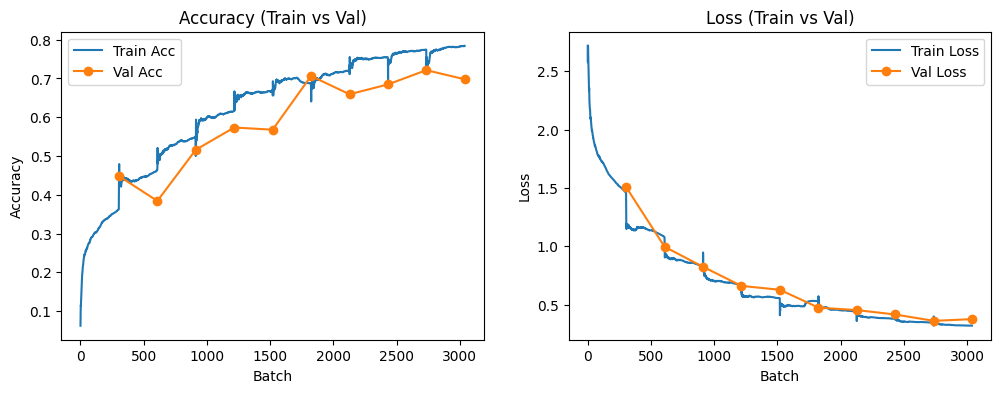


Epoch 10: val_loss did not improve from 0.36194
304/304 ━━━━━━━━━━━━━━━━━━━━ 224s 735ms/step - accuracy: 0.7836 - loss: 0.3212 - val_accuracy: 0.6977 - val_loss: 0.3767


In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_live_plot = BatchLivePlot(display_every=2)  # updates every __ batches

# Define checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath='models/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    batch_live_plot,
    checkpoint_cb
]

model.compile(
    optimizer=optimizer,
    loss=loss_fn,        #sparse_categorical_loss_with_smoothing
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

In [60]:
# Save the model in the new `.keras` format
model_save_path = os.path.join(model_dir, 'model6.keras')
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: models/model6.keras


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.7420 - loss: 0.3464

 Test Accuracy: 0.7420
Test Loss: 0.3464


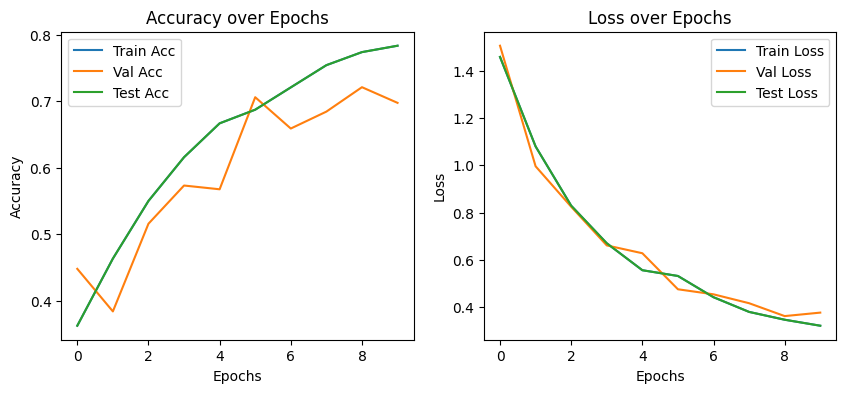

In [61]:
# --- 4. Evaluate Model ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# --- 5. Plot Training Curves ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['accuracy'], label='Test Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['loss'], label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()
plt.show()


In [62]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7420 - loss: 0.3464
Test Accuracy: 0.7420
Test Loss: 0.3464


In [63]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step
Confusion Matrix:
 [[ 18   0   0   0   2   0   0   0   0   0]
 [ 17 232   5   3   7  25   8   0   4   0]
 [  0   0  23   0   2   0   0   0   0   0]
 [  9   3   0 141  80   4  32   0   0   0]
 [  0   0   1   4 193   3   3   0   0   0]
 [ 14   0   2   6  10  56   0   0   0   0]
 [  0   1   1  12  11   2  72   0   0   1]
 [  0   0   0   0   0   0   0   3   0   0]
 [  0   0   0   0   0   0   0   0  25   0]
 [  1   0   0   0   0   1   0   0   0  25]]
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.31      0.90      0.46        20
                           Diabetic Retinopathy       0.98      0.77      0.86       301
                                     Disc Edema       0.72      0.92      0.81        25
                                       Glaucoma       0.85      0.52      0.65       269
                                        Healthy       0.63     

2025-11-09 09:19:10.735477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(class_names, per_class_acc):
    print(f"{cls}: {acc:.4f}")


Central Serous Chorioretinopathy [Color Fundus]: 0.9000
Diabetic Retinopathy: 0.7708
Disc Edema: 0.9200
Glaucoma: 0.5242
Healthy: 0.9461
Macular Scar: 0.6364
Myopia: 0.7200
Pterygium: 1.0000
Retinal Detachment: 1.0000
Retinitis Pigmentosa: 0.9259


In [65]:
# print all layers with dtype
for layer in model.layers:
    print(f"{layer.name}: {layer.dtype}")

input_layer_4: float32
rescaling_4: float32
conv2d_24: float32
batch_normalization_28: float32
activation_28: float32
conv2d_25: float32
batch_normalization_29: float32
activation_29: float32
max_pooling2d_20: float32
dropout_28: float32
conv2d_26: float32
batch_normalization_30: float32
activation_30: float32
global_average_pooling2d_14: float32
dense_28: float32
dense_29: float32
reshape_10: float32
multiply_10: float32
max_pooling2d_21: float32
dropout_29: float32
conv2d_27: float32
batch_normalization_31: float32
activation_31: float32
global_average_pooling2d_15: float32
dense_30: float32
dense_31: float32
reshape_11: float32
multiply_11: float32
max_pooling2d_22: float32
dropout_30: float32
conv2d_28: float32
batch_normalization_32: float32
activation_32: float32
global_average_pooling2d_16: float32
dense_32: float32
dense_33: float32
reshape_12: float32
multiply_12: float32
max_pooling2d_23: float32
dropout_31: float32
conv2d_29: float32
batch_normalization_33: float32
activatio

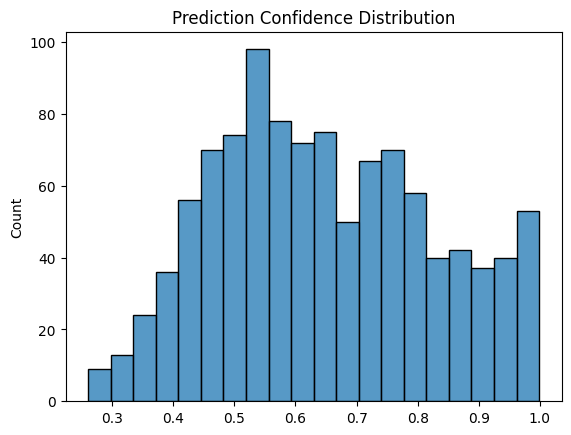

In [66]:
import seaborn as sns

probs_max = np.max(y_pred_probs, axis=1)
sns.histplot(probs_max, bins=20)
plt.title("Prediction Confidence Distribution")
plt.show()
